# 1.0 IMPORTS

In [2]:
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm
from boruta  import BorutaPy
from sklearn.metrics import top_k_accuracy_score


import os
import pickle
import requests
import pandas            as pd
import seaborn           as sns
import boruta            as bt
import numpy             as np
import scikitplot        as skplt

import pickle
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier

## 1.1 Carregamento dos dados

In [3]:
df = pd.read_csv('../dataset/dados_tratados.csv')

In [4]:
df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,mais_de_2_anos,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,entre_1_e_2_anos,1,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,mais_de_2_anos,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,menos_de_1_ano,1,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,menos_de_1_ano,1,27496.0,152.0,39,0


In [5]:
df1 = df.copy()

# 2.0 Data preparation

In [6]:
# Separação feature e target
X = df.drop(columns='response')
y = df['response']

x_train, x_val, y_train, y_val = ms.train_test_split(
    X,y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

df1 = pd.concat([x_train, y_train], axis=1)

## 2.1 Standardization

In [7]:
ss = StandardScaler()

# anual premium - StandarScaler
df1['annual_premium'] = ss.fit_transform(df1[['annual_premium']] )
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

## 2.2 Rescaling

In [8]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df1['age'] = mms_age.fit_transform( df1[['age']] )
pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df1['vintage'] = mms_vintage.fit_transform( df1[['vintage']] )
pickle.dump( mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb') )

## 2.3 Transformation

### 2.3.1 Encoding

In [9]:
def target_encode(df1, column, target, filename):
    mapping = df1.groupby(column)[target].mean()
    df1[column] = df1[column].map(mapping)
    pickle.dump(mapping, open(f'../src/features/{filename}.pkl', 'wb'))
    return df1

def frequency_encode(df1, column, filename):
    mapping = df1[column].value_counts(normalize=True)
    df1[column] = df[column].map(mapping)
    pickle.dump(mapping, open(f'../src/features/{filename}.pkl', 'wb'))
    return df1

# Aplicações
df1 = target_encode(df1, 'gender', 'response', 'target_encode_gender_scaler')
df1 = target_encode(df1, 'region_code', 'response', 'target_encode_region_code_scaler')
df1 = frequency_encode(df1, 'policy_sales_channel', 'fe_policy_sales_channel_scaler')

# Vehicle_age - One Hot Encoding
df1 = pd.get_dummies(df1, prefix='vehicle_age', columns=['vehicle_age'])

## 2.4 Validation Preparation

In [10]:
# Carregamento dos arquivo pickle
target_encode_gender = pickle.load(open('../src/features/target_encode_gender_scaler.pkl', 'rb'))
target_encode_region_code = pickle.load(open('../src/features/target_encode_region_code_scaler.pkl', 'rb'))
fe_policy_sales_channel = pickle.load(open('../src/features/fe_policy_sales_channel_scaler.pkl', 'rb'))

def preprocess_validation_data(x_val):
# Target encoding
    x_val['gender'] = x_val['gender'].map(target_encode_gender)
    x_val['region_code'] = x_val['region_code'].map(target_encode_region_code)
    x_val['policy_sales_channel']  = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# Scaling (Normalization / Standardization)
    x_val['age'] = mms_age.transform(x_val[['age']])
    x_val['annual_premium'] = ss.transform(x_val[['annual_premium']])
    x_val['vintage'] = mms_vintage.transform(x_val[['vintage']])

# One-Hot Encoding
    x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

    x_val = x_val.fillna(0)

    return x_val

# 3.0 Feature Selection

## 3.1 Boruta Algorithm

In [11]:
# Separa X e y
x_train_n = df1.drop(columns=['id', 'response'])
y_train_n = y_train.values.ravel()

et_model = ExtraTreesClassifier(n_jobs=-1)

# Inicializa o Boruta
boruta = BorutaPy(
    estimator=et_model,
    n_estimators='auto',
    verbose=2,
    random_state=42
)

# Ajuste do Boruta ao conjunto de dados
boruta.fit(x_train_n.values, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	9
Iteration:

BorutaPy(estimator=ExtraTreesClassifier(n_estimators=24, n_jobs=-1,
                                        random_state=RandomState(MT19937) at 0x1F955D15840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1F955D15840, verbose=2)

In [12]:
# colunas selecionadas pelo Boruta
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df1.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# colunas que não foram selecionadas pelo Boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 3.2 Feature Importance

In [13]:
# Definição do modelo
forest = en.ExtraTreesClassifier(
    n_estimators=250,
    random_state=0,
    n_jobs=-1
)

# Preparação dos dados
x_train_n = df1.drop(columns=['id', 'response'])
y_train_n = y_train.values

# Treinamento do modelo
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                         feature  importance
8                        vintage    0.280907
6                 annual_premium    0.252729
1                            age    0.168457
3                    region_code    0.105119
4             previously_insured    0.096679
7           policy_sales_channel    0.063227
11    vehicle_age_menos_de_1_ano    0.015358
9   vehicle_age_entre_1_e_2_anos    0.008843
0                         gender    0.004519
10    vehicle_age_mais_de_2_anos    0.003705
2                driving_license    0.000456
5                 vehicle_damage    0.000000


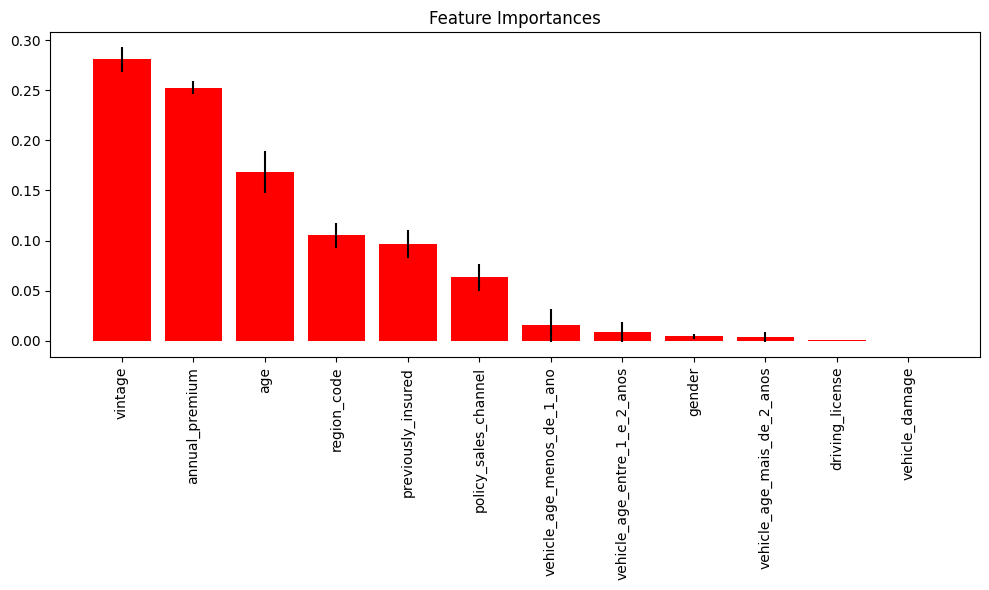

In [14]:
# Importancia das features
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances) [: :-1]

# Construção do ranking em DataFrame
feature_name = x_train_n.columns
ranking_df = pd.DataFrame({
    'feature' : feature_name,
    'importance' : importances
}).sort_values(by='importance', ascending=False)

# Exibição do ranking
print("Feature Ranking:")
print(ranking_df)

# Plot das importancias
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), feature_name[indices], rotation=90)
plt.xlim([-1, x_train_n.shape[1]])
plt.tight_layout()
plt.show()


# 4.0 Machine Learning Modelling

## 4.1 KNN Classifier

In [15]:
x_val = preprocess_validation_data(x_val)

# Agora use as colunas corretas:
x_train = df1[cols_selected_boruta]
x_val = x_val[cols_selected_boruta]  

# Alinha colunas para garantir que tudo bate
x_train, x_val = x_train.align(x_val, join='left', axis=1, fill_value=0)

# Treinamento do modelo
knn_model = nh.KNeighborsClassifier(n_neighbors=7)
knn_model.fit(x_train, y_train)

# Previsões
yhat_knn = knn_model.predict_proba(x_val)

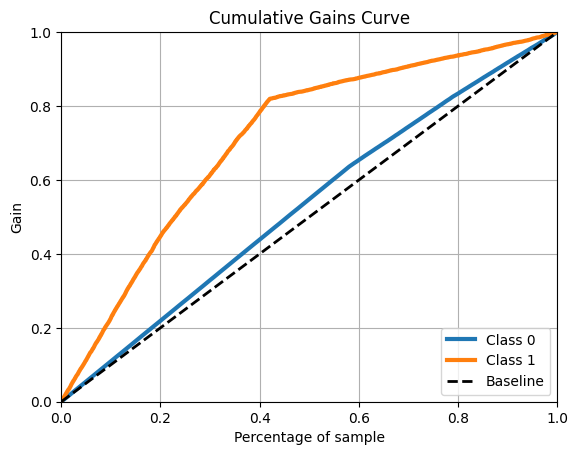

In [16]:
# Gráfico de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)
plt.show()

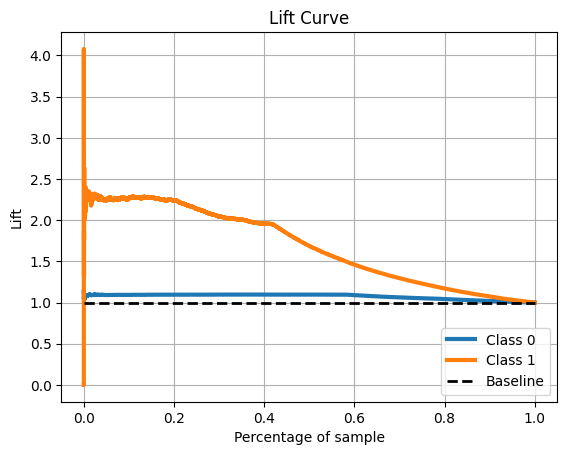

In [17]:
# Gráfico Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_knn )
plt.show()

## 4.2 Logistic Regression

In [18]:
# Definição do modelo
lr_model = lm.LogisticRegression( random_state=42 ) 

# Treinamento do modelo
lr_model.fit( x_train, y_train )

# previsão
yhat_lr = lr_model.predict_proba( x_val )

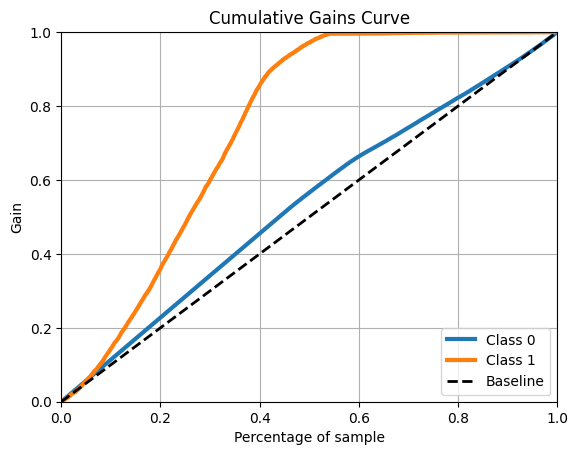

In [19]:
# Gráfico de ganho cumulativo
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr )
plt.show()

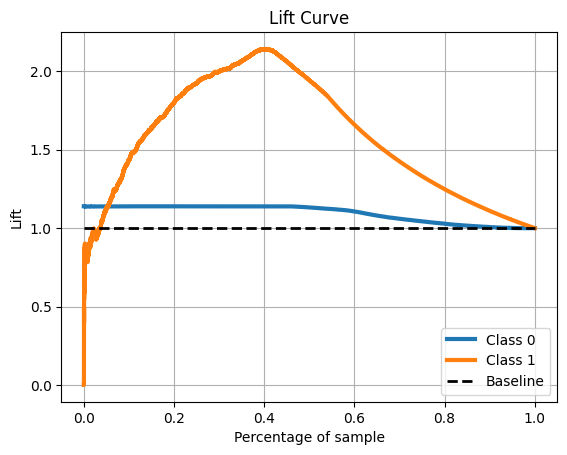

In [20]:
# Grafico Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lr )
plt.show()

## 4.3 Extra Trees Classifier

In [21]:
# Definição do modelo
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# Treinamento do modelo
et.fit( x_train, y_train )

# previsão
yhat_et = et.predict_proba( x_val )

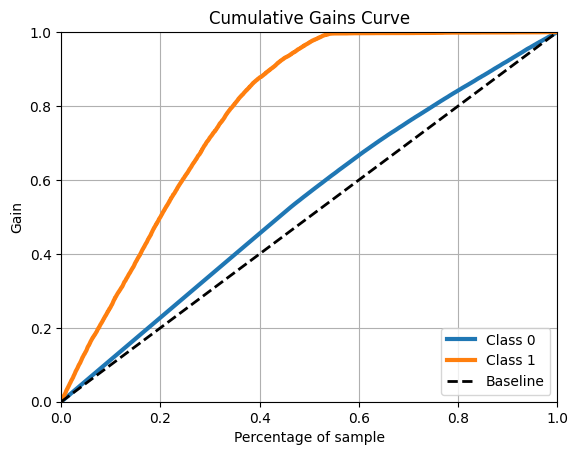

In [22]:
# Gráfico de ganho cumulativo
skplt.metrics.plot_cumulative_gain( y_val, yhat_et )
plt.show()

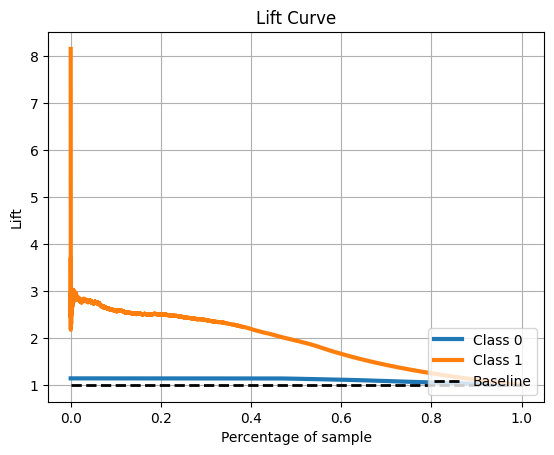

In [23]:
# Grafico Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et )
plt.show()

## 4.4 Random Forest

In [24]:
# Definição do modelo
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# Treinamento do modelo
rf.fit( x_train, y_train )

# Previsão
yhat_rf = et.predict_proba( x_val )

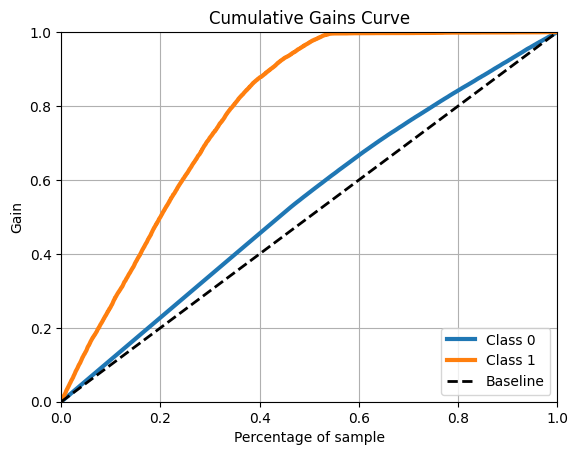

In [25]:
# Gráfico de ganho cumulativo
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf )
plt.show()

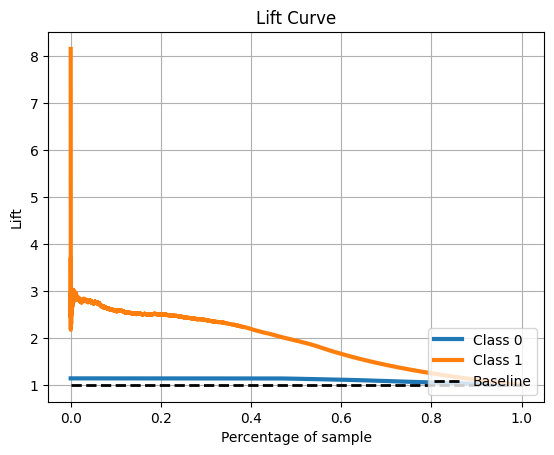

In [26]:
# Grafico Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf )
plt.show()

# 5.0 Métricas de desempenho

In [27]:
def precisao_k(dados, k=10):
    # Reinicia os índices do DataFrame
    dados = dados.reset_index(drop=True)
    
    # Criação da coluna ranking
    dados['ranking'] = dados.index + 1
    
    # Calcula a soma acumulada das respostas positivas
    dados['precisao_k'] = dados['response'].cumsum() / dados['response']
    
    # Retorna a precisão 
    return (dados.loc[k-1, 'precisao_k'], dados)

In [28]:
def recall_k(dados, k=15):
    # Reinicia os índices do DataFrame
    dados = dados.reset_index(drop=True)
    
    # Criação da coluna ranking
    dados['ranking'] = dados.index + 1
    
    # Calcula o recall acumulado, positivos encontrados / total de positivos
    dados['recall_k'] = dados['response'].cumsum() / dados['response'].sum()
    
    # Retorna o recall 
    return (dados.loc[k-1, 'recall_k'], dados)

In [29]:
# Cópia dataframe
df2 = x_val.copy()
df2 ['response'] = y_val.copy()

# Probabilidade prevista
df2['score'] = yhat_et[:, 1].tolist()

# Clientes com maior probabilidade de resposta
df2 = df2.sort_values( 'score', ascending=False )

# Cálculo da precisão
precisao_k, data = precisao_k(df2, k=20)

# Cálculo de Recall
recall_k, data = recall_k( df2, k=15 )


In [30]:
y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # para o primeiro exemplo
                    [0.3, 0.4, 0.2],  # para o segundo exemplo
                    [0.2, 0.4, 0.3],  # para o terceiro exemplo
                    [0.7, 0.2, 0.1]]) # para o quarto exemplo
top_k_accuracy_score(y_true, y_score, k=2)

np.float64(0.75)

In [31]:
y_true = np.array( [1, 0, 1, 1, 0, 1, 0, 0] )
y_score = np.array( [])

## 5.1 Curva acumulada manual

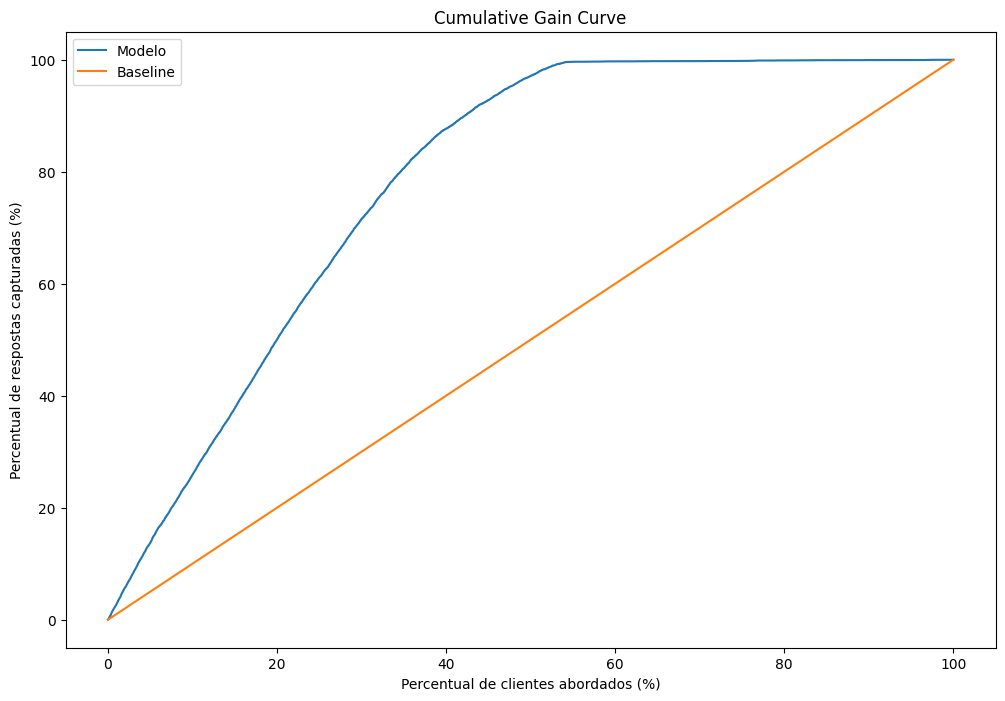

In [32]:
# Cria DataFrame com previsões e valores reais
results = pd.DataFrame({
    'prediction': yhat_et[:, 1],
    'real': y_val
})

# Ordena pelas maiores probabilidades previstas
results = results.sort_values('prediction', ascending=False).reset_index(drop=True)

# Calcula curva cumulativa
total_real = results['real'].sum()

results = results.assign(
    real_cum = results['real'].cumsum(),
    real_cum_perc = 100 * results['real'].cumsum() / total_real,
    base = range(1, len(results) + 1),
    base_cum_perc = 100 * (np.arange(1, len(results)+1)) / len(results),
    baseline = 100 * (np.arange(1, len(results)+1)) / len(results)
)

# Plotando a Cumulative Gain Curve
plt.figure(figsize=(12,8))
sns.lineplot(x='base_cum_perc', y='real_cum_perc', data=results, label='Modelo')
sns.lineplot(x='base_cum_perc', y='baseline', data=results, label='Baseline',)

plt.title('Cumulative Gain Curve')
plt.xlabel('Percentual de clientes abordados (%)')
plt.ylabel('Percentual de respostas capturadas (%)')
plt.legend()
plt.show()


## 5.2 Lift curve manual

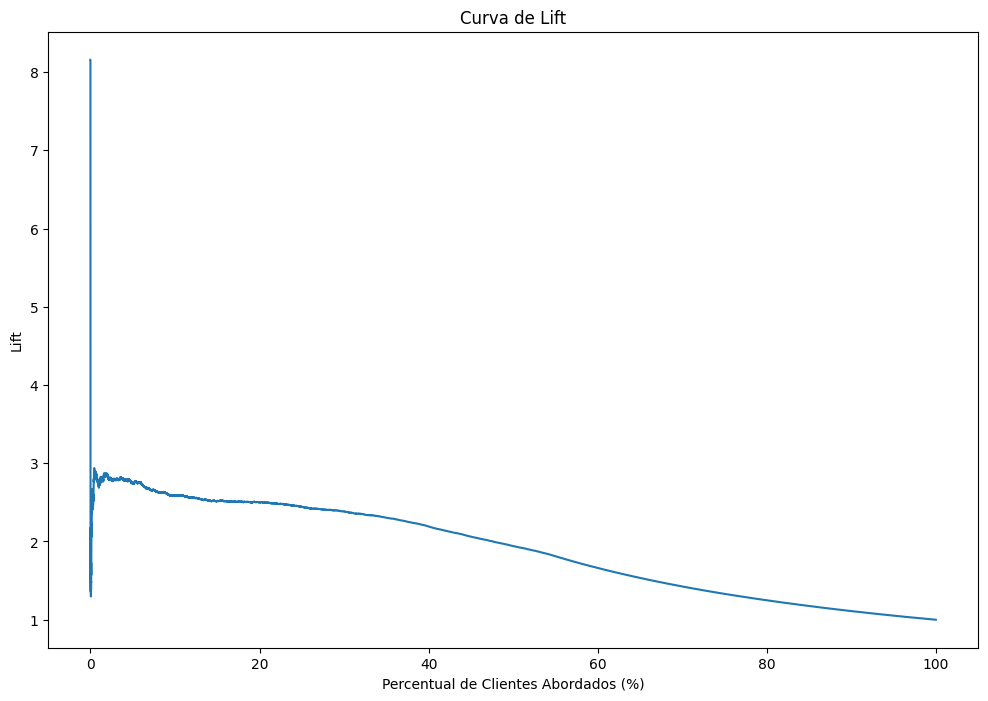

In [33]:

# Criação do DataFrame com as previsões e valores reais
results = pd.DataFrame({
    'prediction': yhat_et[:, 1],
    'real': y_val
})

# Ordena pelos maiores valores de predição
results = results.sort_values('prediction', ascending=False).reset_index(drop=True)

# Cálculo do acumulado de respostas reais
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100 * results['real_cum'] / results['real'].sum()

# Cálculo da base de clientes (percentual)
results['base'] = np.arange(1, len(results) + 1)
results['base_cum_perc'] = 100 * results['base'] / len(results)

# Baseline (modelo aleatório)
results['baseline'] = results['base_cum_perc']

# Cálculo do Lift
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# Plot da curva de Lift
plt.figure(figsize=(12, 8))
sns.lineplot(x='base_cum_perc', y='lift', data=results)

# Adiciona informações no gráfico para melhor interpretação
plt.title('Curva de Lift')
plt.xlabel('Percentual de Clientes Abordados (%)')
plt.ylabel('Lift')
plt.show()

## 5.3 ROI curve manual

In [34]:
results = pd.DataFrame({
    'prediction': yhat_et[:, 1].copy(),
    'real': y_val
})

# Ordena pela maior probabilidade prevista
results = results.sort_values('prediction', ascending=False)

# Acúmulo percentual de casos positivos
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100 * results['real_cum'] / results['real'].sum()

# Acúmulo percentual da base
results['base'] = np.arange(1, len(results) + 1)
results['base_cum_perc'] = 100 * results['base'] / len(results)

# Linha de referência aleatória
results['baseline'] = results['base_cum_perc']

# Cálculo do Lift (com proteção contra divisão por zero)
results['lift'] = results['real_cum_perc'] / results['base_cum_perc'].replace(0, np.nan)


In [35]:
# Criação dos buckets usando pandas.cut
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results['bucket'] = pd.cut(results['prediction'], bins=bins, labels=labels, include_lowest=True, right=True)

# Agrupamento por bucket com média de propensão
dft = results.groupby('bucket', observed=True).agg(
    clients=('prediction', 'count'),
    propensity_score=('prediction', 'mean')
).reset_index()

# Cálculo de receita bruta e custo
dft['gross_revenue'] = 40 * dft['clients'] * dft['propensity_score']
dft['cost'] = 4 * dft['clients']

# Receita líquida
dft['revenue'] = dft['gross_revenue'] - dft['cost']

# Ordenação correta por bucket 
dft = dft.sort_values('bucket', ascending=False)

# Cálculo da base acumulada 
dft['base'] = dft['clients'].cumsum() / dft['clients'].sum()

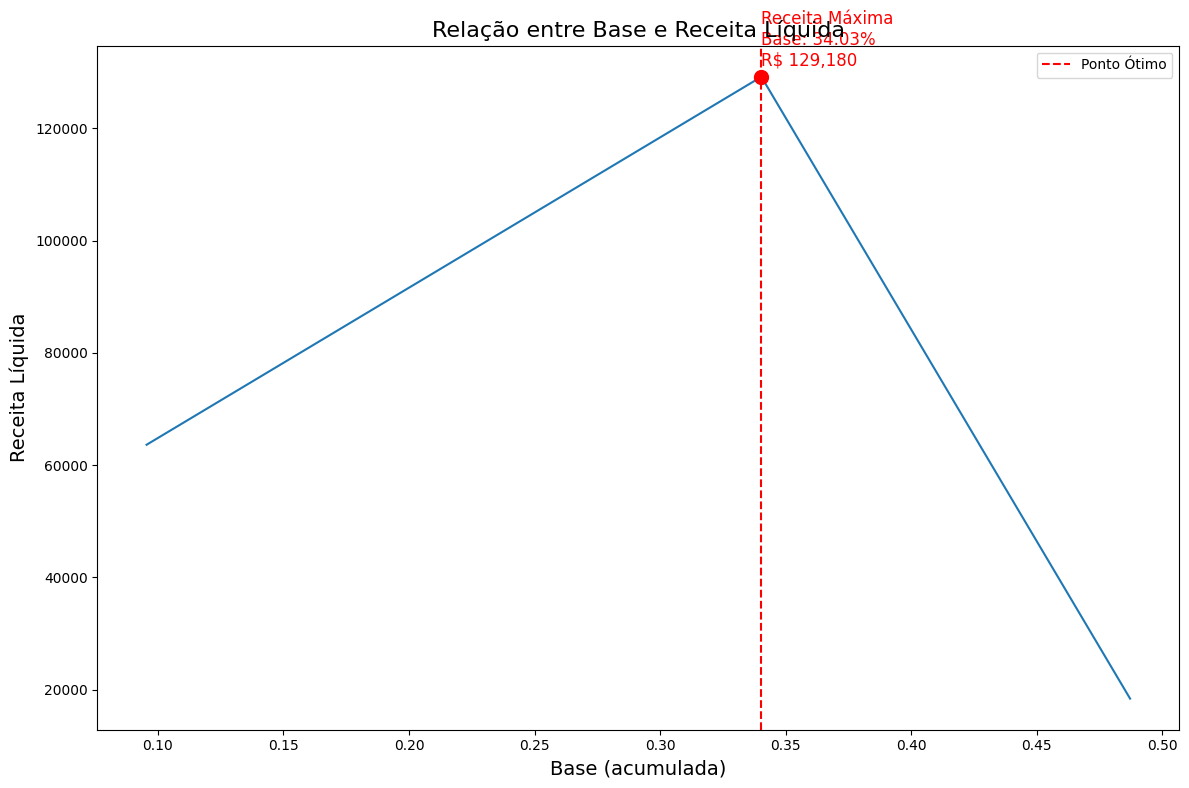

In [36]:
# Encontrar o ponto de receita máxima
max_revenue_idx = dft['revenue'].idxmax()
max_revenue_base = dft.loc[max_revenue_idx, 'base']
max_revenue_value = dft.loc[max_revenue_idx, 'revenue']

# Plot
plt.figure(figsize=(12, 8))
aux = dft[dft['propensity_score'] >= 0.1]
sns.lineplot(x='base', y='revenue', data=aux)

# Anotar ponto ótimo
plt.axvline(x=max_revenue_base, color='red', linestyle='--', label='Ponto Ótimo')
plt.scatter(max_revenue_base, max_revenue_value, color='red', s=100, zorder=5)
plt.text(max_revenue_base, max_revenue_value + 2000,
         f'Receita Máxima\nBase: {max_revenue_base:.2%}\nR$ {max_revenue_value:,.0f}',
         color='red', fontsize=12)

# Título e eixos
plt.title('Relação entre Base e Receita Líquida', fontsize=16)
plt.xlabel('Base (acumulada)', fontsize=14)
plt.ylabel('Receita Líquida', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


# 6.0 Deploy em produção

In [37]:
# Caminho para a raiz do projeto
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) 

# Caminho para o diretório onde o modelo será salvo
model_dir = os.path.join(project_root, 'src', 'models')
model_filename = 'model_logistic_regression.pkl'
model_path = os.path.join(model_dir, model_filename)

# Garante que a pasta existe
os.makedirs(model_dir, exist_ok=True)

# Salva o modelo
with open(model_path, 'wb') as file:
    pickle.dump(lr_model, file)

# Caminho para salvar as features selecionadas
features_path = os.path.join(model_dir, 'selected_features.pkl')

# Salva as colunas selecionadas pelo Boruta
with open(features_path, 'wb') as file:
    pickle.dump(cols_selected_boruta, file)